In [3]:
import pandas as pd
import numpy as np
import os
import py_vollib_vectorized
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [4]:
def create_market_state(BCAST_FILE, expiry_time, get_greeks=True, mf_lower = -0.2, mf_upper = 0.2, RESAMPLING = 's'):
    '''
    Creates and return Market State in a multiIndex Format
    '''
    bcast_file = BCAST_FILE
    bcast_data = pd.read_csv(bcast_file, index_col=0)
    bcast_data = bcast_data[~(bcast_data.bidPrice_1.isna() & bcast_data.askPrice_1.isna())]
    bcast_data = bcast_data[['bidPrice_1', 'askPrice_1', 'strike', 'instrument_type', 'sec']].sort_values('sec')
    bcast_data['midPrice'] = (bcast_data.bidPrice_1 + bcast_data.askPrice_1)/2
    bcast_data.instrument_type = bcast_data.instrument_type.str.strip('"').astype(str)
    bcast_data.strike = bcast_data.strike.str.strip('"').astype(int)
    bcast_data['futPrice'] = np.where(bcast_data.instrument_type == 'XX', bcast_data.midPrice, np.nan)
    bcast_data.futPrice = bcast_data.futPrice.ffill()
    bcast_data.index = pd.to_datetime(bcast_data.index).tz_convert(None)
    bcast_data['time_to_expiry'] = (expiry_time - bcast_data.index).total_seconds()/(86400*365)
    bcast_data.instrument_type = bcast_data.instrument_type.map({'XX' : 'f', 'CE' : 'c', 'PE' : 'p'})
    bcast_data = bcast_data[~(bcast_data.instrument_type == 'f')]
    bcast_data = bcast_data[((bcast_data.instrument_type == 'p') & (bcast_data.strike < bcast_data.futPrice)) | ((bcast_data.instrument_type == 'c') & (bcast_data.strike > bcast_data.futPrice))]
    bcast_data['spread'] = bcast_data.askPrice_1 - bcast_data.bidPrice_1
    bcast_data['moneyness'] = np.log(bcast_data.strike/bcast_data.futPrice)
    if state_type == 'iv':
        bcast_data['bid_iv'] = py_vollib_vectorized.vectorized_implied_volatility(bcast_data.bidPrice_1, bcast_data.futPrice, bcast_data.strike, bcast_data.time_to_expiry,  0, bcast_data.instrument_type, return_as='numpy')
        bcast_data['ask_iv'] = py_vollib_vectorized.vectorized_implied_volatility(bcast_data.askPrice_1, bcast_data.futPrice, bcast_data.strike, bcast_data.time_to_expiry,  0, bcast_data.instrument_type, return_as='numpy')
        bcast_data['mid_iv'] = (bcast_data.bid_iv + bcast_data.ask_iv)/2
        bcast_data['spread'] = bcast_data.ask_iv - bcast_data.bid_iv
        
        value_columns =  ['bid_iv', 'ask_iv', 'mid_iv', 'moneyness', 'spread', 'futPrice', 'time_to_expiry', 'bidPrice_1', 'askPrice_1']
        if get_greeks:
            greeks = py_vollib_vectorized.get_all_greeks(bcast_data.instrument_type, bcast_data.futPrice, bcast_data.strike,  bcast_data.time_to_expiry,  0, bcast_data.mid_iv, return_as='dataframe')
            bcast_data = bcast_data.reset_index().assign(**greeks).set_index('index')
            value_columns.extend(greeks.columns)
        curve_state = bcast_data.pivot_table(values = value_columns, index=bcast_data.index, columns=['strike']).ffill().resample(RESAMPLING).last().ffill()
        curve_state = curve_state.stack()
        curve_state['futPrice'] = curve_state.index.get_level_values(0).map(bcast_data.futPrice.resample(RESAMPLING).last().ffill().reset_index().set_index('index').futPrice.to_dict())
        curve_state = curve_state[(curve_state.moneyness > mf_lower) & (curve_state.moneyness < mf_upper) ]
    
    return curve_state

In [5]:
import numpy as np
from scipy.stats import norm
def calc_d1(S, K, T, r, y, sigma):
  return (np.log(S/K) + (r-y)*T)/(sigma * np.sqrt(T)) + sigma * np.sqrt(T)/2

def calc_d2(S, K, T, r, y, sigma):
  return calc_d1(S, K, T, r, y, sigma) - sigma*np.sqrt(T)

def option_price(S, K, T, r, y, sigma):
  return (S * np.exp(-y*T) * norm.cdf(calc_d1(S, K, T, r, y, sigma)) 
         - K * np.exp(-r*T) * norm.cdf(calc_d2(S, K, T, r, y, sigma)))

In [6]:
#option_price(740.2, 900, 0.003889, 0, 0, 1.219748)
#curve_state1.loc['2021-06-23 15:30:00'].copy()

In [7]:
date = '20210623'
stock = 'AXISBANK'
expiry_date = '20210624'

expiry_time = datetime.strptime(expiry_date, '%Y%m%d') + timedelta(hours = 20)
BCAST_FILE = f"./data/{date}/influxOP_{stock + expiry_time.strftime('%y%b').upper()}_{date}.csv"
RESAMPLING = '30s'
curve_state1, bcast_data1 = create_market_state(BCAST_FILE, expiry_time, RESAMPLING=RESAMPLING)

In [8]:
curve_state1

askPrice_1    ask_iv  bidPrice_1    bid_iv  \
index               strike                                               
2021-06-23 09:15:00 69000         85.0  0.735749         5.0  0.468670   
                    70000         50.0  0.551682        25.0  0.485601   
                    71000        400.0  0.807324        45.0  0.430901   
                    72000        110.0  0.401694        70.0  0.354363   
                    73000        400.0  0.465147       125.0  0.275265   
...                                ...       ...         ...       ...   
2021-06-23 15:30:00 84000         10.0  0.834980         5.0  0.772323   
                    85000         10.0  1.029546         5.0  0.954448   
                    87000         10.0  1.177264         5.0  1.093481   
                    88000         20.0  1.361683         5.0  1.166281   
                    90000         10.0  1.219748         5.0  1.135067   

                               delta  futPrice     gamma    mid_iv  moneyness  \
index               strike                                                      
2021-06-23 09:15:00 69000  -0.027282   74165.0  0.000022  0.602210  -0.072186   
                    70000  -0.037061   74165.0  0.000033  0.518641  -0.057797   
                    71000  -0.127548   74165.0  0.000072  0.619112  -0.043612   
                    72000  -0.104497   74165.0  0.000103  0.378029  -0.029626   
                    73000  -0.244857   74165.0  0.000182  0.370206  -0.015833   
...                              ...       ...       ...       ...        ...   
2021-06-23 15:30:00 84000   0.006225   73360.0  0.000005  0.803652   0.123413   
                    85000   0.005465   73360.0  0.000004  0.991997   0.147204   
                    87000   0.004869   73360.0  0.000003  1.135372   0.170086   
                    88000   0.006381   73360.0  0.000003  1.263982   0.182265   
                    90000   0.004328   73360.0  0.000002  1.177407   0.195474   

                                 rho    spread       theta  time_to_expiry  \
index               strike                                                   
2021-06-23 09:15:00 69000  -0.081426  0.267079  -29.605012        0.003966   
                    70000  -0.110449  0.066081  -35.997530        0.003966   
                    71000  -0.382594  0.376423 -174.152064        0.003966   
                    72000  -0.310902  0.047331  -84.787634        0.003966   
                    73000  -0.730302  0.189882 -202.663573        0.003966   
...                              ...       ...         ...             ...   
2021-06-23 15:30:00 84000   0.016849  0.062656   -7.191430        0.003703   
                    85000   0.013090  0.075098   -7.188584        0.003325   
                    87000   0.011471  0.083784   -7.186042        0.003276   
                    88000   0.014896  0.195402  -10.693159        0.003258   
                    90000   0.012180  0.084680   -7.183231        0.003889   

                                 vega  
index               strike             
2021-06-23 09:15:00 69000    2.936924  
                    70000    3.782240  
                    71000    9.749970  
                    72000    8.461244  
                    73000   14.676242  
...                               ...  
2021-06-23 15:30:00 84000    0.794137  
                    85000    0.662275  
                    87000    0.593433  
                    88000    0.751750  
                    90000    0.587004  

[15503 rows x 14 columns]

In [29]:
df1 = curve_state1.loc['2021-06-23 15:30:00'].copy()
coeffs1 = np.polyfit(df1['moneyness'], df1['mid_iv'], deg=3)
poly1 = np.poly1d(coeffs1)

In [30]:
date = '20210624'
stock = 'AXISBANK'
expiry_date = '20210624'

expiry_time = datetime.strptime(expiry_date, '%Y%m%d') + timedelta(hours = 20)
BCAST_FILE = f"./data/{date}/influxOP_{stock + expiry_time.strftime('%y%b').upper()}_{date}.csv"
RESAMPLING = '30s'
curve_state2, bcast_data2 = create_market_state(BCAST_FILE, expiry_time, RESAMPLING=RESAMPLING)

In [31]:
df2 = curve_state2.loc['2021-06-24 15:29:00'].copy()
coeffs2 = np.polyfit(df2['moneyness'], df2['mid_iv'], deg=3)
poly2 = np.poly1d(coeffs2)

<AxesSubplot:xlabel='moneyness'>

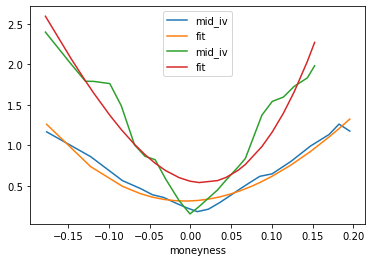

In [32]:
df1['fit'] = poly1(df1['moneyness'])
df2['fit'] = poly2(df2['moneyness'])
ax = plt.gca()

df1.set_index('moneyness')[['mid_iv', 'fit']].plot(ax=ax)
df2.set_index('moneyness')[['mid_iv', 'fit']].plot(ax=ax)

In [33]:
coeffs1

array([-21.71499478,  28.78591094,   0.37565037,   0.3150123 ])

In [34]:
coeffs2

array([112.07101584,  71.64896255,  -2.27201459,   0.55829304])

In [35]:
df1

ask_iv    bid_iv     delta  futPrice     gamma  \
index               strike                                                     
2021-06-23 15:30:00 62000   1.240297  1.095823 -0.005370   73360.0  0.000003   
                    65000   0.896413  0.827546 -0.006086   73360.0  0.000005   
                    68000   0.589867  0.541718 -0.008293   73360.0  0.000009   
                    69000   0.488577  0.446481 -0.010704   73360.0  0.000014   
                    70000   0.432191  0.352493 -0.018132   73360.0  0.000027   
                    71000   0.380109  0.336231 -0.053608   73360.0  0.000073   
                    72000   0.303910  0.281217 -0.129292   73360.0  0.000172   
                    73000   0.233473  0.230255 -0.352495   73360.0  0.000383   
                    74000   0.185256  0.181042  0.204318   73360.0  0.000370   
                    75000   0.221073  0.205645  0.035092   73360.0  0.000087   
                    76000   0.309141  0.280038  0.016433   73360.0  0.000033   
                    77000   0.401390  0.365792  0.012924   73360.0  0.000021   
                    78000   0.488594  0.447028  0.010860   73360.0  0.000015   
                    79000   0.572637  0.525529  0.009402   73360.0  0.000011   
                    80000   0.644857  0.593128  0.008417   73360.0  0.000009   
                    82000   0.675682  0.623100  0.007347   73360.0  0.000007   
                    84000   0.834980  0.772323  0.006225   73360.0  0.000005   
                    85000   1.029546  0.954448  0.005465   73360.0  0.000004   
                    87000   1.177264  1.093481  0.004869   73360.0  0.000003   
                    88000   1.361683  1.166281  0.006381   73360.0  0.000003   
                    90000   1.219748  1.135067  0.004328   73360.0  0.000002   

                              mid_iv  moneyness       rho    spread  \
index               strike                                            
2021-06-23 15:30:00 62000   1.168060  -0.176187 -0.014596  0.144474   
                    65000   0.861979  -0.122218 -0.014816  0.068867   
                    68000   0.565793  -0.083205 -0.023707  0.048150   
                    69000   0.467529  -0.061000 -0.025777  0.042096   
                    70000   0.392342  -0.046611 -0.043621  0.079698   
                    71000   0.358170  -0.032699 -0.129053  0.043879   
                    72000   0.292563  -0.018713 -0.311160  0.022693   
                    73000   0.231864  -0.004919 -0.848816  0.003218   
                    74000   0.183149   0.008686  0.484773  0.004214   
                    75000   0.213359   0.022109  0.083349  0.015428   
                    76000   0.294590   0.036002  0.038978  0.029104   
                    77000   0.383591   0.049245  0.030894  0.035598   
                    78000   0.467811   0.061603  0.025679  0.041566   
                    79000   0.549083   0.074069  0.022204  0.047109   
                    80000   0.618993   0.085149  0.019948  0.051729   
                    82000   0.649391   0.100191  0.021153  0.052582   
                    84000   0.803652   0.123413  0.016849  0.062656   
                    85000   0.991997   0.147204  0.013090  0.075098   
                    87000   1.135372   0.170086  0.011471  0.083784   
                    88000   1.263982   0.182265  0.014896  0.195402   
                    90000   1.177407   0.195474  0.012180  0.084680   

                                 theta       vega       fit  
index               strike                                   
2021-06-23 15:30:00 62000    -9.035814   0.683198  1.261161  
                    65000    -7.194101   0.722615  0.738723  
                    68000    -7.199763   1.034559  0.495552  
                    69000    -7.207116   1.184157  0.404138  
                    70000   -10.875671   1.864633  0.362242  
                    71000   -34.212255   4.560512  0.334267  
                    72000   -79.416111   8.814386  0.318205

<AxesSubplot:xlabel='index,strike'>

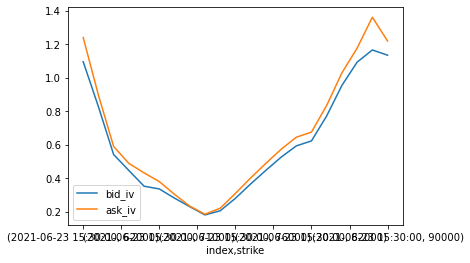

In [37]:
curve_state1.loc['2021-06-23 15:30:00'][['bid_iv', 'ask_iv']].plot()

In [38]:
coeffs = np.polyfit(df2['moneyness'], df2['mid_iv'], deg=3)
poly = np.poly1d(coeffs)
# df['fit_%d' % deg] = poly(df['moneyness'])

<AxesSubplot:xlabel='moneyness'>

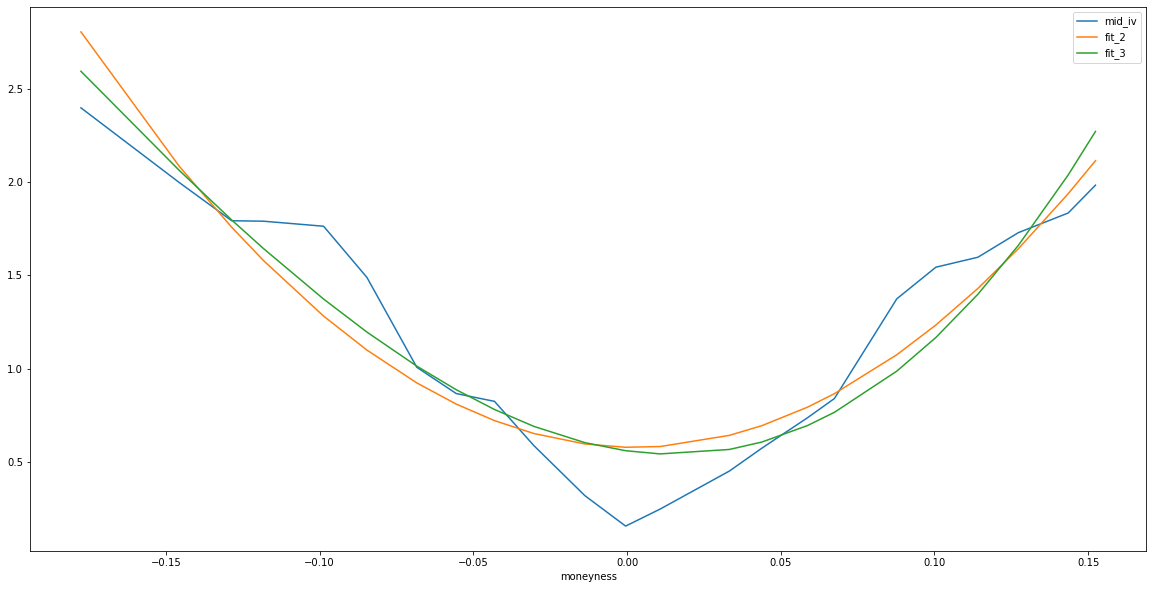

In [39]:
r = range(2, 4)

for deg in r:
    poly = np.poly1d(np.polyfit(df2['moneyness'], df2['mid_iv'], deg=deg))
    df2['fit_%d' % deg] = poly(df2['moneyness'])

df2.set_index('moneyness')[['mid_iv'] + ['fit_%d' % deg for deg in r]].plot(figsize=(20,10))

In [ ]:
# Make Dataframe of Random EOD Posiitons
100CE = 2 lot
100PE = 3 lot
 
Delta hedge    -1Fut
    
+0.2 lot


take the Curve of Day 1 EOD: Calculate individul prices 
take the Curve of Day 2 BOD: Calculate individul prices 
    
Calculate Pnl <--- ANSWER



model vol() as a polynomial of moneyness = log(S/K), with coeff_i


Delta Pnl : delta* Futprice_chg
gamma pnl : gamma * delta change
theta pnl : theta* time_to_exp chg

    
+= coeff_sensitivity(i) * change_in_coeff(i)


coeff of x^i in pol(x) where x = ln(S/k)

coeff_sensitivity(i) = how sensitive is the option price to the coeffecient i in the IV formula
(greek)              = d BSP(vol, ..) / d_coeff_i  
                     = d BSP(vol, ..) / d vol * d vol / d_coeff_i
                     = vega * (log(moneyness) ^ i)

# which vol to use for vega? (ATM or of the option)
# weight inv prop to spread of the option

vega is just coeff_sesitivity(0)

    

In [ ]:
NSE : BHAVCOPY

In [ ]:
ln(k/m)^2